In [25]:

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download

cluster_df=pd.read_csv('/Users/apple/Desktop/Business Project/data/cluster_df.csv')
def preprocess_sentence(sentence):
    # Ensure the input is a string
    sentence = str(sentence)

    # Convert the sentence to lowercase
    sentence = sentence.lower()

    # Remove punctuation
    sentence = re.sub(r'[^\w\s]', '', sentence)

    # Remove non-alphanumeric characters
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)

    # Define stop words
    stop_words = set(stopwords.words('english'))

    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Add additional stop words
    additional_words = {'el', 'ge','la', 'de', 'br','mi','na','que','one','se','lo','en'}
    stop_words.update(additional_words)

    # Remove stop words and perform lemmatization
    sentence = ' '.join([lemmatizer.lemmatize(word) for word in sentence.split() if word not in stop_words])

    # Remove extra whitespace
    sentence = re.sub(r'\s+', ' ', sentence).strip()

    return sentence



cluster_df['Progress Sentence'] = cluster_df['Sentence'].apply(preprocess_sentence)






[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [53]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
import re

review_data = cluster_df['Progress Sentence']
labels = cluster_df['Category'].apply(lambda x: int(re.search(r'\d+', x).group()) - 1)

k = 7
# 划分数据至各个聚类
clustered_sentences = [[] for i in range(k)]
for sentence, cluster_id in zip(review_data, labels):
    clustered_sentences[cluster_id].append(sentence)

# 字典用来储存所有聚类的主题数据
cluster_topics_dict = {}
# 逐个聚类应用TF-IDF和LDA
for i, sentences in enumerate(clustered_sentences):
    print(f"\nCluster {i+1}:")
    vectorizer = TfidfVectorizer(max_df=0.85, min_df=5, stop_words='english')
    X = vectorizer.fit_transform(sentences)
    
    lda = LatentDirichletAllocation(n_components=7, max_iter=20, random_state=42)
    lda.fit(X)
    
    # 展示每个聚类的主题关键词
    def display_topics(model, feature_names, no_top_words):
        topics = {}
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            topics[f"Topic {topic_idx}"] = ", ".join(top_features)
        return topics
    
    topic_keywords = display_topics(lda, vectorizer.get_feature_names_out(), 15)
    print("Top words per topic:", topic_keywords)

    # 将聚类编号和其主题关键词添加到字典
    cluster_topics_dict[f"Cluster {i+1}"] = topic_keywords

# 输出存储有主题关键词的字典
print(cluster_topics_dict)



Cluster 1:
Top words per topic: {'Topic 0': 'easy, good, install, great, value, installed, like, work, water, working, price, product, quality, taste, exactly', 'Topic 1': 'price, install, easy, minute, saved, took, video, money, le, youtube, great, cheaper, work, cost, buy', 'Topic 2': 'look, easy, nice, install, light, hood, great, love, fan, quiet, good, work, product, installed, installation', 'Topic 3': 'problem, easy, install, fixed, job, instruction, issue, old, installing, installation, water, cheap, instal, installed, broke', 'Topic 4': 'install, easy, screw, need, use, work, installation, make, instruction, old, time, dryer, installed, product, new', 'Topic 5': 'perfect, easy, install, fast, arrived, quick, quickly, delivery, fit, came, shipping, replacement, time, great, expected', 'Topic 6': 'easy, install, work, great, perfectly, worked, replace, installation, use, product, fit, super, ease, simple, fine'}

Cluster 2:
Top words per topic: {'Topic 0': 'perfectly, good, gre

   Topic 0  Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6
0     4163    15755     1761     3179     6942     5179     5752
1    21262     2633     1622     3954     5812     3453     3024
2     4991      986     1110    29810     3069     2651     1439
3      791      392    40929     2056     5003    11190     2680
4    49884    32723    18775     9165    10706    24792    13938
5     8918      995     7316     7401    31922    16995    39413
6     3575      822    45302     1483    16163    14729     1821


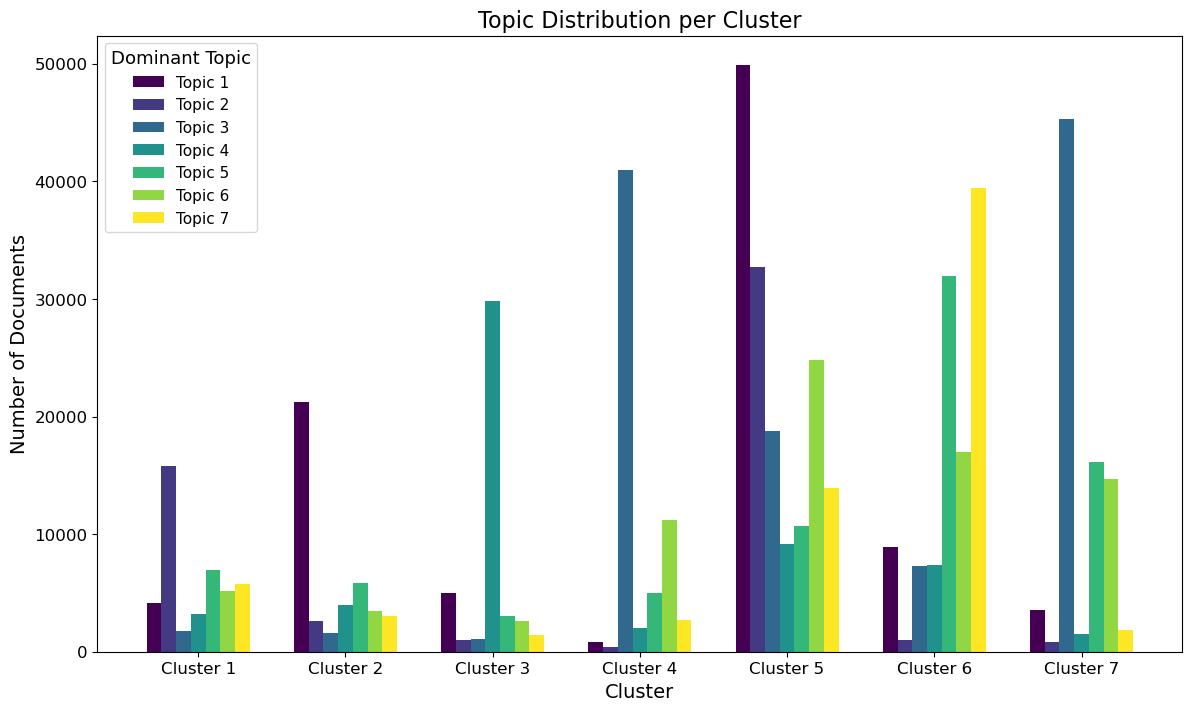

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 将文档的主题概率最大值转换为主题索引
dominant_topics = np.argmax(doc_topic, axis=1)

# 创建一个空的DataFrame用于存储结果
topic_distribution = pd.DataFrame(0, index=np.arange(k), columns=['Topic '+str(i) for i in range(7)])

# 计算每个聚类中每个主题的文档数
for cluster in range(k):
    for topic in range(7):
        # 计算当前聚类中指定主题的文档数
        topic_distribution.loc[cluster, 'Topic '+str(topic)] = np.sum((labels == cluster) & (dominant_topics == topic))

print(topic_distribution)



n_clusters = topic_distribution.shape[0]  # clusters num
n_topics = topic_distribution.shape[1]  # topic num
cluster_labels = ['Cluster {}'.format(i+1) for i in range(n_clusters)]

# plot
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.1  
indices = np.arange(n_clusters) 
colors = plt.cm.viridis(np.linspace(0, 1, n_topics))

for i in range(n_topics):
    ax.bar(indices + i * bar_width, topic_distribution.iloc[:, i], width=bar_width, label='Topic {}'.format(i + 1), color=colors[i])

# 添加图例和标签
ax.set_xlabel('Cluster', fontsize=14)
ax.set_ylabel('Number of Documents', fontsize=14)
ax.set_title('Topic Distribution per Cluster', fontsize=16)
ax.set_xticks(indices + bar_width * (n_topics - 1) / 2)
ax.set_xticklabels(cluster_labels)
ax.legend(title='Dominant Topic', title_fontsize='13', fontsize='11')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=0)  # 旋转x轴标签，确保文本不重叠

plt.show()



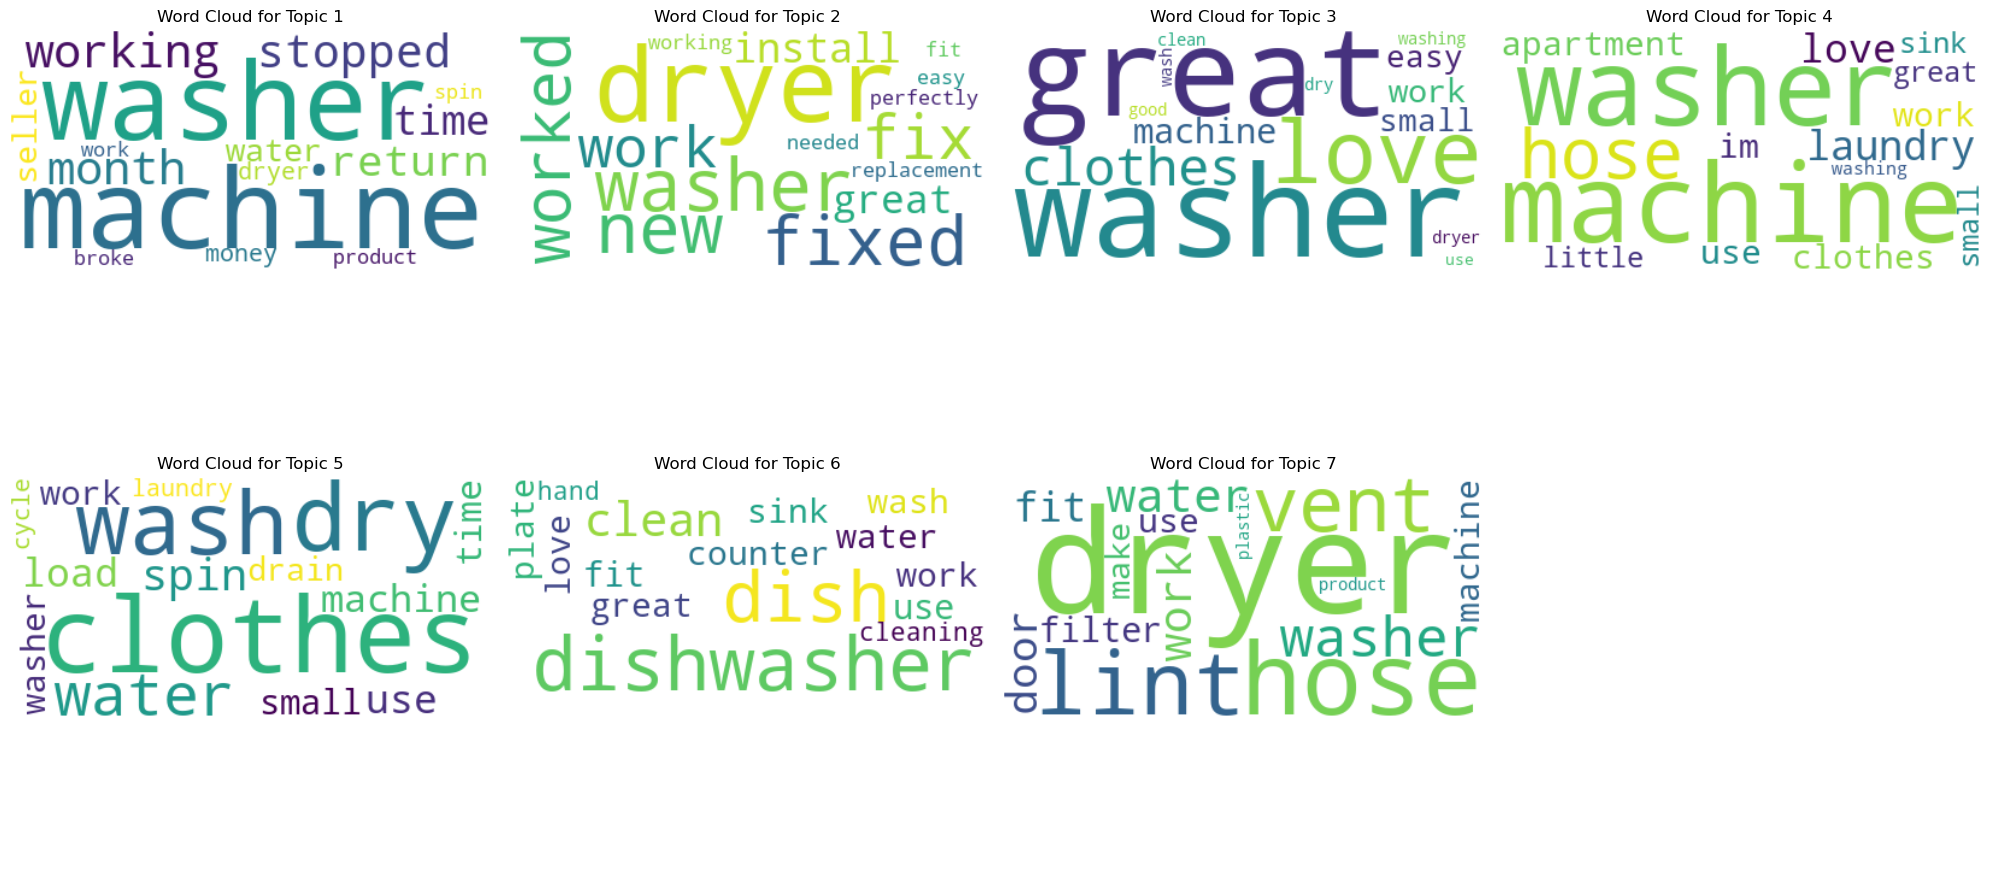

In [58]:
"""import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings

warnings.filterwarnings("ignore")

# Assuming 'vectorizer' and 'lda' are already fitted with your data
feature_names = vectorizer.get_feature_names_out()

# Number of top words to display in the word cloud
num_top_words = 15

# Set up the figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust the layout size as needed
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop through each topic to generate word clouds
for topic_idx, topic in enumerate(lda.components_):
    word_weights = {feature_names[i]: topic[i] for i in topic.argsort()[-num_top_words:][::-1]}
    
    # Generate the word cloud
    wordcloud = WordCloud(
        width=400,
        height=200,
        background_color='white'
    ).generate_from_frequencies(word_weights)

    # Display each word cloud in a subplot
    ax = axes[topic_idx]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Word Cloud for Topic {topic_idx+1}")
    ax.axis("off")

# Hide any unused subplots if there are fewer than 8 topics
for i in range(len(lda.components_), 8):
    axes[i].axis("off")

plt.tight_layout()
plt.show()"""
